# Install NVIDIA Modulus

In [79]:
!pip install nvidia-modulus nvidia-modulus-sym

# Import Required Libraries

In [80]:
import os
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
from sympy import Symbol, Eq, Abs

For educational purposes, we will actually import the NVIDIA Modulus modules in parts as we need them.

But you can import them from the beginning like this.

In [81]:
# import modulus.sym
# from modulus.sym.hydra import to_absolute_path, instantiate_arch, ModulusConfig
# from modulus.sym.solver import Solver
# from modulus.sym.domain import Domain
# from modulus.sym.geometry.primitives_2d import Rectangle
# from modulus.sym.domain.constraint import (
#     PointwiseBoundaryConstraint,
#     PointwiseInteriorConstraint,
#     # PointwiseConstraint
# )
# # from modulus.sym.domain.validator import PointwiseValidator
# from modulus.sym.domain.inferencer import PointwiseInferencer
# from modulus.sym.key import Key
# from modulus.sym.eq.pdes.navier_stokes import NavierStokes
# from modulus.sym.utils.io import (
#     csv_to_dict,
#     ValidatorPlotter,
#     InferencerPlotter
# )

# Navier Stokes PDEs

I recommend you check out the GitHub repository of NVIDIA modulus where this equation is defined:

https://github.com/NVIDIA/modulus-sym/blob/main/modulus/sym/eq/pdes/navier_stokes.py

In [82]:
from modulus.sym.eq.pdes.navier_stokes import NavierStokes

In [83]:
ns = NavierStokes(nu=0.01, rho=1.0, dim=2, time=False)

In [84]:
ns.equations

{'continuity': 1.0*Derivative(u(x, y), x) + 1.0*Derivative(v(x, y), y),
 'momentum_x': 1.0*u(x, y)*Derivative(u(x, y), x) + 1.0*v(x, y)*Derivative(u(x, y), y) + Derivative(p(x, y), x) - 0.01*Derivative(u(x, y), (x, 2)) - 0.01*Derivative(u(x, y), (y, 2)),
 'momentum_y': 1.0*u(x, y)*Derivative(v(x, y), x) + 1.0*v(x, y)*Derivative(v(x, y), y) + Derivative(p(x, y), y) - 0.01*Derivative(v(x, y), (x, 2)) - 0.01*Derivative(v(x, y), (y, 2))}

In [85]:
ns.pprint()

continuity: 1.0*u__x + 1.0*v__y
momentum_x: 1.0*u*u__x + 1.0*v*u__y + p__x - 0.01*u__x__x - 0.01*u__y__y
momentum_y: 1.0*u*v__x + 1.0*v*v__y + p__y - 0.01*v__x__x - 0.01*v__y__y


In [86]:
ns.equations['continuity']

    ∂                 ∂          
1.0⋅──(u(x, y)) + 1.0⋅──(v(x, y))
    ∂x                ∂y         

In [87]:
ns.equations['momentum_x']

                                                                         2    
            ∂                         ∂             ∂                   ∂     
1.0⋅u(x, y)⋅──(u(x, y)) + 1.0⋅v(x, y)⋅──(u(x, y)) + ──(p(x, y)) - 0.01⋅───(u(x
            ∂x                        ∂y            ∂x                   2    
                                                                       ∂x     

               2         
              ∂          
, y)) - 0.01⋅───(u(x, y))
               2         
             ∂y          

In [88]:
ns.equations['momentum_y']

                                                                         2    
            ∂                         ∂             ∂                   ∂     
1.0⋅u(x, y)⋅──(v(x, y)) + 1.0⋅v(x, y)⋅──(v(x, y)) + ──(p(x, y)) - 0.01⋅───(v(x
            ∂x                        ∂y            ∂y                   2    
                                                                       ∂x     

               2         
              ∂          
, y)) - 0.01⋅───(v(x, y))
               2         
             ∂y          

# Neural Network

The docs recommend defining the neural network architecture with a configuration file:

https://docs.nvidia.com/deeplearning/modulus/modulus-sym/user_guide/basics/lid_driven_cavity_flow.html#creating-a-neural-network-node

But we'll do it with code ;)

This is because we want to understand what actually happens behind the scenes a little better, and that is why I also recommend you check out the `arch.py` file in the NVIDIA Modulus repository where the data classes are defined:

https://github.com/NVIDIA/modulus-sym/blob/f59eba4d852a65cc80f703da754a87e51ba44d9d/modulus/sym/hydra/arch.py#L94

In [89]:
# from modulus.sym.models.fully_connected import FullyConnectedArch
# from modulus.sym.models.activation import Activation
# from modulus.sym.key import Key

# # Explicit declaration
# flow_net = FullyConnectedArch(
#     # Science & Engineering Knowledge
#     input_keys=[Key("x"), Key("y")],
#     output_keys=[Key("u"), Key("v"), Key("p")],
#     # Neural Networks Knowledge (You don't need to know...)
#     layer_size=512,
#     nr_layers=6,
#     skip_connections=False,
#     activation_fn=Activation.SILU,
#     adaptive_activations=False,
#     weight_norm=True
# )

In [90]:
# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Explicit declaration
flow_net = FullyConnectedArch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u"), Key("v"), Key("p")],
    layer_size=512,
    nr_layers=6,
    skip_connections=False,
    activation_fn=Activation.SILU,
    adaptive_activations=False,
    weight_norm=True
).to(device)  # Move the model to the correct device

Using device: cuda


In [91]:
flow_net

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=2, out_features=512, bias=True)
      )
      (1-5): 5 x FCLayer(
        (linear): WeightNormLinear(in_features=512, out_features=512, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=512, out_features=3, bias=True)
    )
  )
)

In [94]:
nodes = ns.make_nodes() + [flow_net.make_node(name="flow_network")]

In [95]:
nodes

# Geometry

In [96]:
from modulus.sym.geometry.primitives_2d import Rectangle

height = 0.1
width = 0.1
x, y = Symbol('x'), Symbol('y')
rec = Rectangle((-width/2, -height/2), (width/2, height/2))

In [97]:
rec

# Constraints

## Domain

In [98]:
from modulus.sym.domain import Domain

ldc_domain = Domain()

## Boundary Constraints

In [99]:
from modulus.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
    PointwiseConstraint
)

In [100]:
# top wall
top_wall = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={
        "u": 1.0, "v": 0
    },
    # batch_size=cfg.batch_size.TopWall
    batch_size=1000,
    lambda_weighting={"u": 1.0 - 20 * Abs(x), "v": 1.0},  # weight edges to be zero
    criteria=(Eq(y, height / 2))  # y = 0.05
)

# no slip
no_slip = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={
        "u": 0, "v": 0
    },
    batch_size=1000,
    criteria = y < height / 2
)

In [101]:
# science engineering here
ldc_domain.add_constraint(top_wall, "top_wall")
ldc_domain.add_constraint(no_slip, "no_slip")

## Interior Constraints

In [102]:
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={
        "continuity": 0, "momentum_x": 0, "momentum_y": 0
    },
    batch_size=4000,
    lambda_weighting={
        "continuity": Symbol("sdf"),
        "momentum_x": Symbol("sdf"),
        "momentum_y": Symbol("sdf")
    }
)
ldc_domain.add_constraint(interior, "interior")
ldc_domain.add_constraint(interior, "interior")

2024-07-05 10:29:28,129 - modulus.sym.graph - INFO - Arch Node: flow_network has been converted to a FuncArch node.


https://docs.nvidia.com/deeplearning/modulus/modulus-sym/user_guide/basics/lid_driven_cavity_flow.html#creating-a-neural-network-node


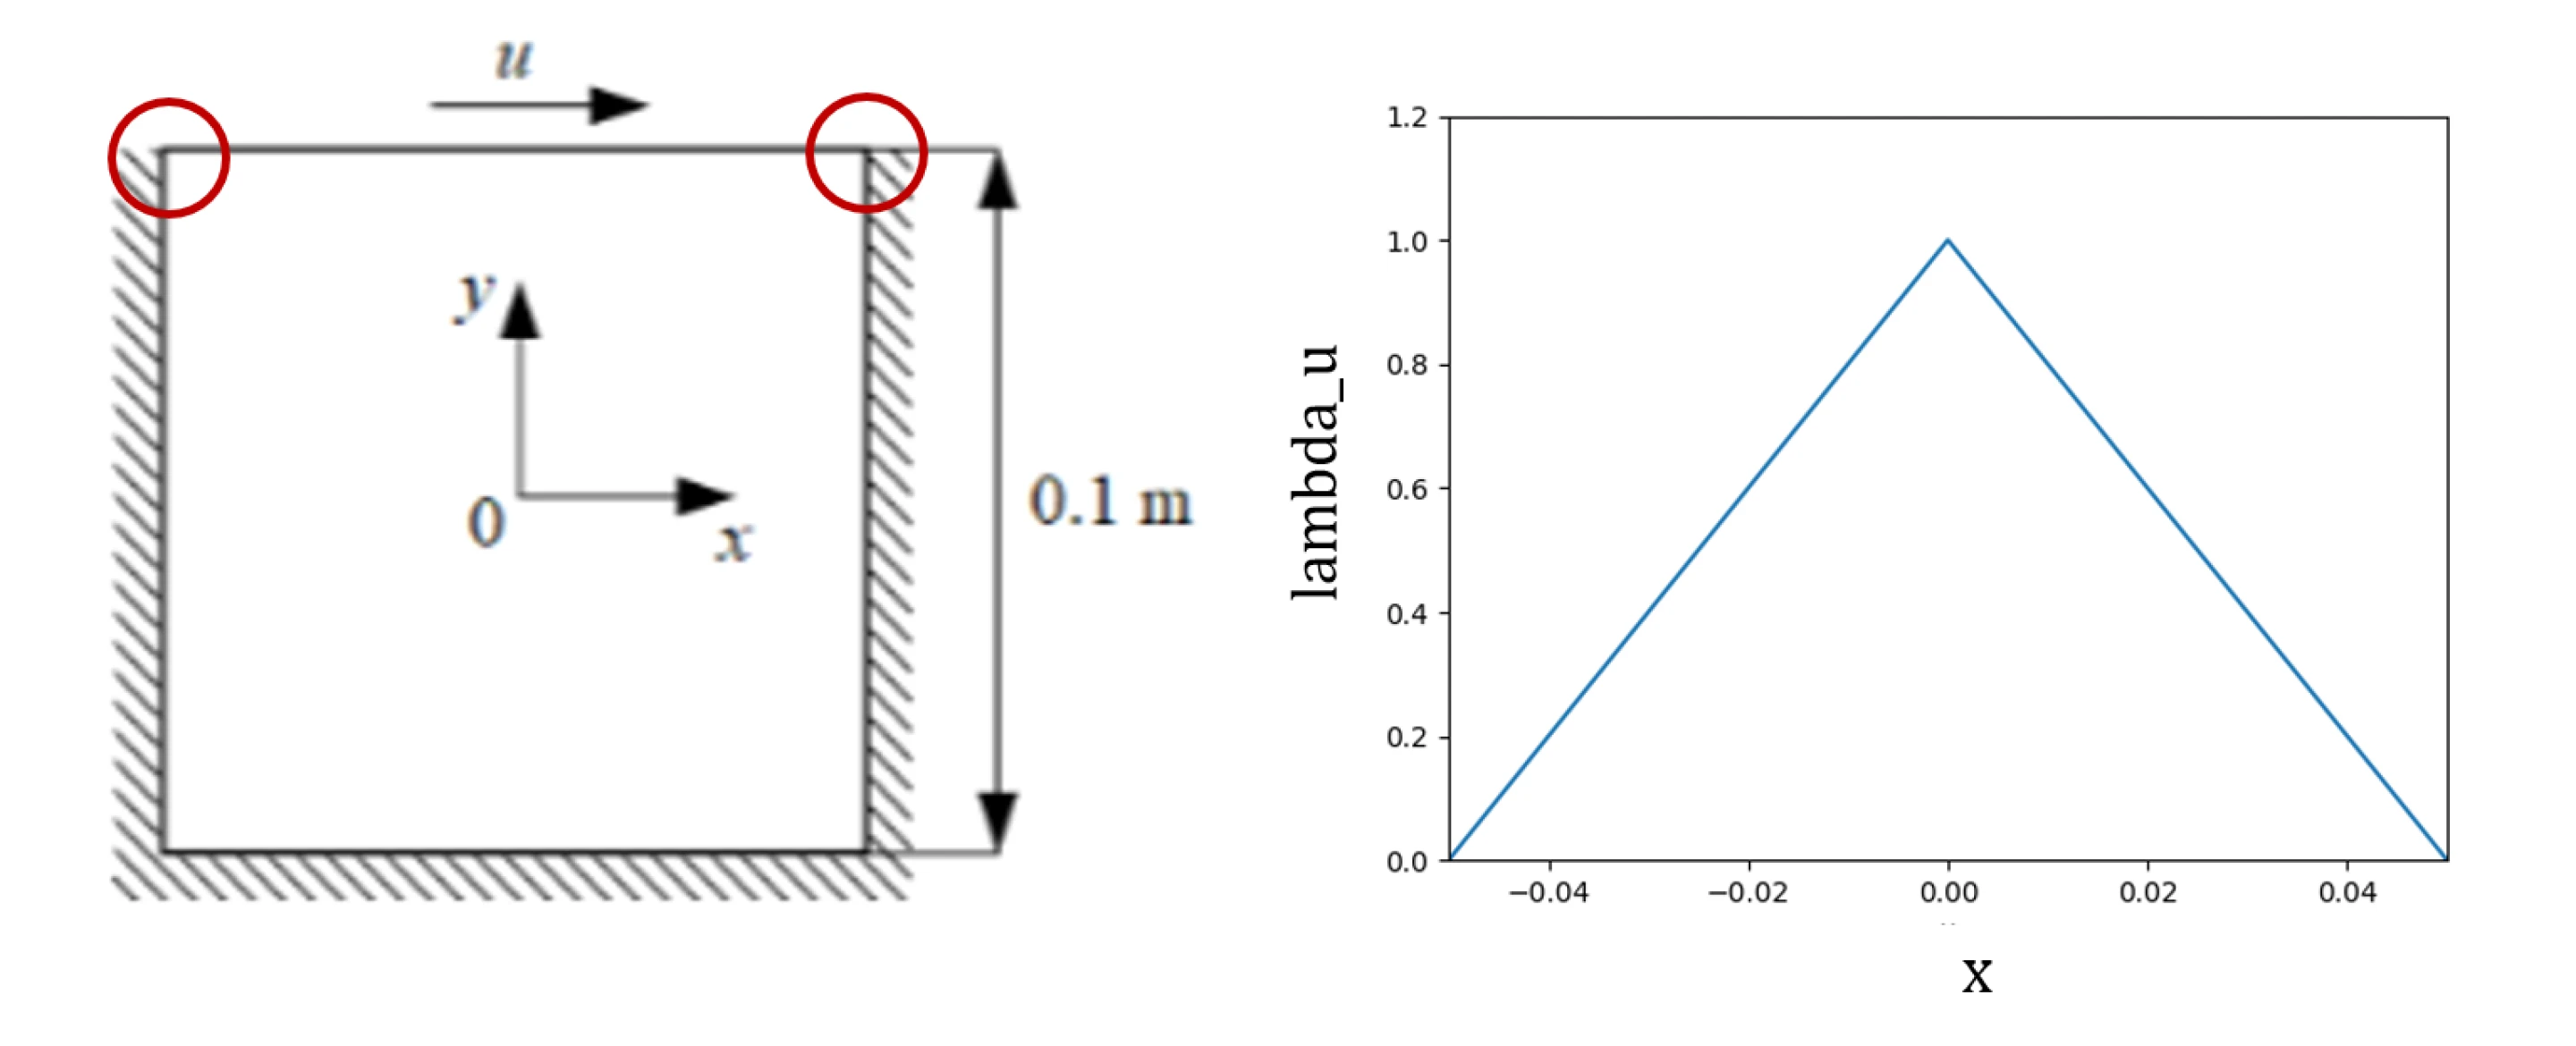

# Solver Configuration

The user guide shows how to convert a configuration file into a configuration object.

https://docs.nvidia.com/deeplearning/modulus/modulus-sym-v110/notebook.nbconvert.html

In [103]:
%%writefile config.yaml

defaults:
  - modulus_default
  - arch: fully_connected
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: sum
  - _self_

scheduler:
  decay_rate: 0.95
  decay_steps: 4000

training:
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  max_steps: 10000

batch_size:
  TopWall: 1000
  NoSlip: 1000
  Interior: 4000

graph:
  func_arch: true


Overwriting config.yaml


In [104]:
import modulus.sym
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra.utils import compose
from modulus.sym.hydra.config import ModulusConfig

cfg = compose(config_path=".", config_name="config")
cfg.network_dir = 'outputs' # Set the network directory for checkpoints
print(to_yaml(cfg))

2024-07-05 10:29:28,191 - hydra.core.utils - DEBUG - Setting JobRuntime:name=app
2024-07-05 10:29:28,427 - modulus.sym.hydra.config - WARNING - TorchScript default is being turned off due to PyTorch version mismatch.


training:
  max_steps: 10000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
graph:
  func_arch: true
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk
summary_histograms: false
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: true
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: false
run_mode: train
arch:
  fully_connected:
    arch_type: fully_connected
    input_keys: ???
    ou

# Create Solver

In [105]:
from modulus.sym.solver import Solver

slv = Solver(cfg, ldc_domain)

# Run Solver

First configure the logging to see the steps!

In [106]:
import logging

# Create a function to configure logging
def configure_logging():
    # Get the root logger
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)

    # Remove all existing handlers
    while logger.handlers:
        logger.handlers.pop()

    # Create a stream handler
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.DEBUG)

    # Create a formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    stream_handler.setFormatter(formatter)

    # Add the handler to the logger
    logger.addHandler(stream_handler)

# Configure logging
configure_logging()

# Test logging
logging.debug("Logging is configured correctly.")

2024-07-05 10:29:28,649 - root - DEBUG - Logging is configured correctly.


In [107]:
# slv.solve()

# Output Files

## Load Model From File

In [108]:
torch.load('./outputs/optim_checkpoint.0.pth').keys()

dict_keys(['step', 'optimizer_state_dict', 'aggregator_state_dict', 'scheduler_state_dict', 'scaler_state_dict'])

In [109]:
torch.load('./outputs/flow_network.0.pth').keys()

odict_keys(['_impl.layers.0.linear.weight', '_impl.layers.0.linear.weight_g', '_impl.layers.0.linear.bias', '_impl.layers.1.linear.weight', '_impl.layers.1.linear.weight_g', '_impl.layers.1.linear.bias', '_impl.layers.2.linear.weight', '_impl.layers.2.linear.weight_g', '_impl.layers.2.linear.bias', '_impl.layers.3.linear.weight', '_impl.layers.3.linear.weight_g', '_impl.layers.3.linear.bias', '_impl.layers.4.linear.weight', '_impl.layers.4.linear.weight_g', '_impl.layers.4.linear.bias', '_impl.layers.5.linear.weight', '_impl.layers.5.linear.weight_g', '_impl.layers.5.linear.bias', '_impl.final_layer.linear.weight', '_impl.final_layer.linear.bias'])

In [110]:
# checkpoint = torch.load('./outputs/optim_checkpoint.0.pth')
checkpoint = torch.load('./outputs/flow_network.0.pth')
try:
    checkpoint.eval()
except AttributeError as error:
    print(error)

# https://stackoverflow.com/a/51812173/8062488 (simiar to this, but not exactly)
# flow_net.load_state_dict(checkpoint['state_dict'])

flow_net.load_state_dict(checkpoint)

'collections.OrderedDict' object has no attribute 'eval'


<All keys matched successfully>

## How to evaluate a PyTorch model

In [111]:
flow_net

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=2, out_features=512, bias=True)
      )
      (1-5): 5 x FCLayer(
        (linear): WeightNormLinear(in_features=512, out_features=512, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=512, out_features=3, bias=True)
    )
  )
)

```
FullyConnectedArch: def _wrapped_call_impl(*args, **kwargs)
Activation.SILU  
[N, size]
[N, size]
>>> arch = .fully_connected.FullyConnectedArch(
>>>    [Key("x", size=2)],
>>>    [Key("y", size=2)],
>>>    layer_size = 64,
>>>    nr_layers = 2)
>>> model = arch.make_node()
>>> input = {"x": torch.randn(64, 2)}
>>> output = model.evaluate(input)
>>> arch = .fully_connected.FullyConnectedArch(
>>>    [Key("x", size=2)],
>>>    [Key("y", size=2)],
>>>    periodicity={'x': (0, 1)})
```

In [112]:
# Example
arch = FullyConnectedArch(
[Key("x", size=2)], # input layer has two values, or is an "x" of dimension 2
[Key("y", size=2)], # output layers also outputs the same kind of thig here
layer_size = 64,
nr_layers = 2)
model = arch.make_node(name="test_model")
input = {"x": torch.randn(10, 2)}
output = model.evaluate(input)
output

{'y': tensor([[ 0.5175,  0.0159],
         [ 0.5745, -0.1067],
         [-0.1469,  0.0331],
         [ 0.4642, -0.4053],
         [ 0.0954, -0.1741],
         [ 0.0889, -0.0145],
         [-0.1256,  0.0683],
         [ 0.5413, -0.1407],
         [-0.1500,  0.0645],
         [-0.3471,  0.3955]], grad_fn=<SplitWithSizesBackward0>)}

In [113]:
arch(input)

{'y': tensor([[ 0.5175,  0.0159],
         [ 0.5745, -0.1067],
         [-0.1469,  0.0331],
         [ 0.4642, -0.4053],
         [ 0.0954, -0.1741],
         [ 0.0889, -0.0145],
         [-0.1256,  0.0683],
         [ 0.5413, -0.1407],
         [-0.1500,  0.0645],
         [-0.3471,  0.3955]], grad_fn=<SplitWithSizesBackward0>)}

In [114]:
torch.randn(10, 2)

tensor([[-0.4089,  0.3108],
        [-1.6430, -0.6739],
        [ 0.5487,  0.3377],
        [ 0.6312, -0.6788],
        [ 0.7210, -0.6597],
        [-1.2249,  1.3132],
        [ 0.5138,  0.9661],
        [ 0.9875, -0.0434],
        [ 0.9860, -0.6755],
        [ 1.3731, -0.3056]])

# How to evaluate **OUR** PyTorch flow model

This is why we instantiated it like this.

```
flow_net = FullyConnectedArch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u"), Key("v"), Key("p")],
    layer_size=512,
    nr_layers=6,
    skip_connections=False,
    activation_fn=Activation.SILU,
    adaptive_activations=False,
    weight_norm=True,
)
```

In [115]:
torch.randn(5, 1)

tensor([[-0.8051],
        [ 1.0672],
        [-0.4259],
        [ 0.6195],
        [-1.9934]])

In [116]:
torch.tensor([0.04])

tensor([0.0400])

In [117]:
torch.rand(5, 1)

tensor([[0.0242],
        [0.1177],
        [0.9308],
        [0.4231],
        [0.0822]])

In [118]:
# A top wall point (x,y) = [0, 0.05]
flow_net({"x": torch.tensor([0]), "y": torch.tensor([0.05])} )

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
(torch.rand(5, 1) * 0.1) - 0.05

In [ ]:
flow_net({"x": (torch.rand(5, 1) * 0.1) -0.05, "y": (torch.rand(5, 1) * 0.1) -0.05} )

In [ ]:
flow_net({"x": torch.tensor([0.05]), "y": torch.tensor([0])} )

# Finally, how to visualize our results

In [ ]:
# Define the domain
x_values = np.linspace(-0.05, 0.05, 100)
y_values = np.linspace(-0.05, 0.05, 100)
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Flatten the grid arrays to create inputs for the model
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Convert to PyTorch tensors
x_tensor = torch.tensor(x_flat, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_flat, dtype=torch.float32).unsqueeze(1)

# Create input dictionary for the model
inputs = {"x": x_tensor, "y": y_tensor}

In [ ]:
# Pass inputs through the model to get predictions
outputs = flow_net(inputs)
u_flat = outputs['u'].detach().numpy()
v_flat = outputs['v'].detach().numpy()
p_flat = outputs['p'].detach().numpy()

# Reshape the outputs back to grid shape
u_grid = u_flat.reshape(x_grid.shape)
v_grid = v_flat.reshape(x_grid.shape)
p_grid = p_flat.reshape(x_grid.shape)

In [ ]:
# Plot the color maps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot p
im0 = axs[0].imshow(p_grid, extent=[-0.05, 0.05, -0.05, 0.05], origin='lower', aspect='auto')
axs[0].set_title('p')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
fig.colorbar(im0, ax=axs[0])

# Plot u
im1 = axs[1].imshow(u_grid, extent=[-0.05, 0.05, -0.05, 0.05], origin='lower', aspect='auto')
axs[1].set_title('u')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
fig.colorbar(im1, ax=axs[1])

# Plot v
im2 = axs[2].imshow(v_grid, extent=[-0.05, 0.05, -0.05, 0.05], origin='lower', aspect='auto')
axs[2].set_title('v')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

In [ ]:
# Define the domain
x_values = np.linspace(-0.05, 0.05, 20)  # Reduced number of points for clearer vector field
y_values = np.linspace(-0.05, 0.05, 20)
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Flatten the grid arrays to create inputs for the model
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Convert to PyTorch tensors
x_tensor = torch.tensor(x_flat, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_flat, dtype=torch.float32).unsqueeze(1)

# Create input dictionary for the model
inputs = {"x": x_tensor, "y": y_tensor}

# Pass inputs through the model to get predictions
outputs = flow_net(inputs)
u_flat = outputs['u'].detach().numpy()
v_flat = outputs['v'].detach().numpy()

# Reshape the outputs back to grid shape
u_grid = u_flat.reshape(x_grid.shape)
v_grid = v_flat.reshape(x_grid.shape)

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(x_grid, y_grid, u_grid, v_grid, scale=10, color='blue')  # Adjust scale as needed
plt.title('Vector Field of u and v')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-0.05, 0.05])
plt.ylim([-0.05, 0.05])
plt.grid(True)
plt.show()

In [ ]:
# Calculate the magnitude of the vectors
magnitude = np.sqrt(u_grid**2 + v_grid**2)

# Plot the vector field with colors
plt.figure(figsize=(8, 6))
plt.quiver(x_grid, y_grid, u_grid, v_grid, magnitude, scale=10, cmap='viridis')  # Adjust scale as needed
plt.colorbar(label='Magnitude')
plt.title('Vector Field of u and v')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-0.05, 0.05])
plt.ylim([-0.05, 0.05])
plt.grid(True)
plt.show()

In [ ]:
# Plot streamlines
plt.figure(figsize=(8, 6))
plt.streamplot(x_grid, y_grid, u_grid, v_grid, color=magnitude, cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('Streamlines of u and v')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-0.05, 0.05])
plt.ylim([-0.05, 0.05])
plt.grid(True)
plt.show()